In [2]:
%matplotlib inline

In [3]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vtk_rw import read_vtk
from ply_rw import read_ply
import lmfit
import pandas as pd
import scipy.stats as stats
from plotting import plot_surf_stat_map, crop_img

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
colors = sns.color_palette('cubehelix', 10)

### Load data

In [7]:
lh_mesh_file = '/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/lh_lowres_new.vtk'
lh_sulc_file = '/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/sulc/lh_sulc.npy'
lh_mask_file = '/scr/ilz3/myelinconnect/new_groupavg/masks/lh_fullmask.npy'
lh_myethick_file = '/scr/ilz3/myelinconnect/new_groupavg/myethick/myethick/smooth_6/lh_myethick_smooth_6.npy'
lh_myeratio_file = '/scr/ilz3/myelinconnect/new_groupavg/myethick/myeratio/smooth_6/lh_myeratio_smooth_6.npy'
lh_t1_file = '/scr/ilz3/myelinconnect/new_groupavg/t1/smooth_6/lh_t1_avg_smooth_6.npy'
lh_embed_file = '/scr/ilz3/myelinconnect/new_groupavg/embed/lh_smooth_3_embed.npy'

rh_mesh_file = '/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/rh_lowres_new.vtk'
rh_sulc_file = '/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/sulc/rh_sulc.npy'
rh_mask_file = '/scr/ilz3/myelinconnect/new_groupavg/masks/rh_fullmask.npy'
rh_myethick_file = '/scr/ilz3/myelinconnect/new_groupavg/myethick/myethick/smooth_6/rh_myethick_smooth_6.npy'
rh_myeratio_file = '/scr/ilz3/myelinconnect/new_groupavg/myethick/myeratio/smooth_6/rh_myeratio_smooth_6.npy'
rh_t1_file = '/scr/ilz3/myelinconnect/new_groupavg/t1/smooth_6/rh_t1_avg_smooth_6.npy'
rh_embed_file = '/scr/ilz3/myelinconnect/new_groupavg/embed/rh_smooth_3_embed.npy'

In [8]:
lv,lf,ld = read_vtk(lh_mesh_file)
lh_mask = np.load(lh_mask_file)
lh_myethick = np.load(lh_myethick_file)
lh_myeratio = np.load(lh_myeratio_file)
lh_t1 = np.load(lh_t1_file)
lh_sulc = np.load(lh_sulc_file)
lh_embed = np.load(lh_embed_file)

rv,rf,rd = read_vtk(rh_mesh_file)
rh_mask = np.load(rh_mask_file)
rh_myethick = np.load(rh_myethick_file)
rh_myeratio = np.load(rh_myeratio_file)
rh_t1 = np.load(rh_t1_file)
rh_sulc = np.load(rh_sulc_file)
rh_embed = np.load(rh_embed_file)

### Mask

In [9]:
rh_myethick[rh_mask]=0
rh_myeratio[rh_mask]=0
rh_t1[rh_mask] = 0
rh_embed[rh_mask] = 0

lh_myethick[lh_mask]=0
lh_myeratio[lh_mask]=0
lh_t1[lh_mask] = 0
lh_embed[lh_mask] = 0

In [10]:
rh_scatter_myethick = np.delete(rh_myethick, rh_mask)
rh_scatter_myeratio = np.delete(rh_myeratio, rh_mask)
rh_scatter_t1 = np.delete(rh_t1, rh_mask)
rh_scatter_embed = np.delete(rh_embed, rh_mask, axis=0)

lh_scatter_myethick = np.delete(lh_myethick, lh_mask)
lh_scatter_myeratio = np.delete(lh_myeratio, lh_mask)
lh_scatter_t1 = np.delete(lh_t1, lh_mask)
lh_scatter_embed = np.delete(lh_embed, lh_mask, axis=0)

#t1_idx=np.where(scatter_t1avg<=1500)
#scatter_t1avg = np.delete(scatter_t1avg, t1_idx)
#scatter_embed_t1 = np.delete(scatter_embed_t1, t1_idx, axis=0)

#r1_idx=np.where(scatter_r1avg>(1./1500))
#scatter_r1avg = np.delete(scatter_r1avg, r1_idx)
#scatter_embed_r1 = np.delete(scatter_embed_r1, r1_idx, axis=0)

### Plot 2D histogramms

In [11]:
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.5)

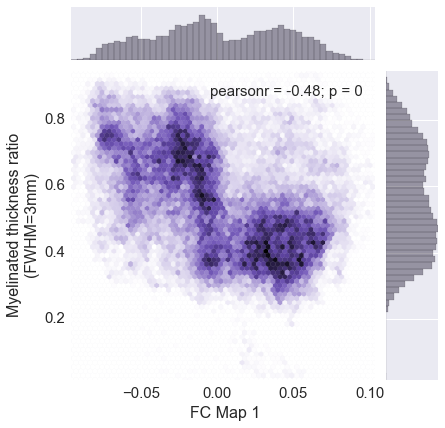

In [12]:
comp=0
g = sns.jointplot(rh_scatter_embed[:,comp], rh_scatter_myeratio, kind="hex", size=6, color=colors[0])
g.set_axis_labels('FC Map %s'%str(comp+1), 'Myelinated thickness ratio\n(FWHM=3mm)', fontsize=16)

### Normalize data to get sensible model comparison

"Note that the calculation of chi-square and reduced chi-square assume that the returned residual function is scaled properly to the uncertainties in the data. For these statistics to be meaningful, the person writing the function to be minimized must scale them properly."

In [13]:
lh_t1_norm = (lh_scatter_t1 - np.mean(lh_scatter_t1)) / (np.std(lh_scatter_t1))
lh_myethick_norm = (lh_scatter_myethick - np.mean(lh_scatter_myethick)) / (np.std(lh_scatter_myethick))
lh_myeratio_norm = (lh_scatter_myeratio - np.mean(lh_scatter_myeratio)) / (np.std(lh_scatter_myeratio))
lh_embed1_norm = (lh_scatter_embed[:,0] - np.mean(lh_scatter_embed[:,0])) / (np.std(lh_scatter_embed[:,0]))
lh_embed2_norm = (lh_scatter_embed[:,1] - np.mean(lh_scatter_embed[:,1])) / (np.std(lh_scatter_embed[:,1]))


rh_t1_norm = (rh_scatter_t1 - np.mean(rh_scatter_t1)) / (np.std(rh_scatter_t1))
rh_myethick_norm = (rh_scatter_myethick - np.mean(rh_scatter_myethick)) / (np.std(rh_scatter_myethick))
rh_myeratio_norm = (rh_scatter_myeratio - np.mean(rh_scatter_myeratio)) / (np.std(rh_scatter_myeratio))
rh_embed1_norm = (rh_scatter_embed[:,0] - np.mean(rh_scatter_embed[:,0])) / (np.std(rh_scatter_embed[:,0]))
rh_embed2_norm = (rh_scatter_embed[:,1] - np.mean(rh_scatter_embed[:,1])) / (np.std(rh_scatter_embed[:,1]))

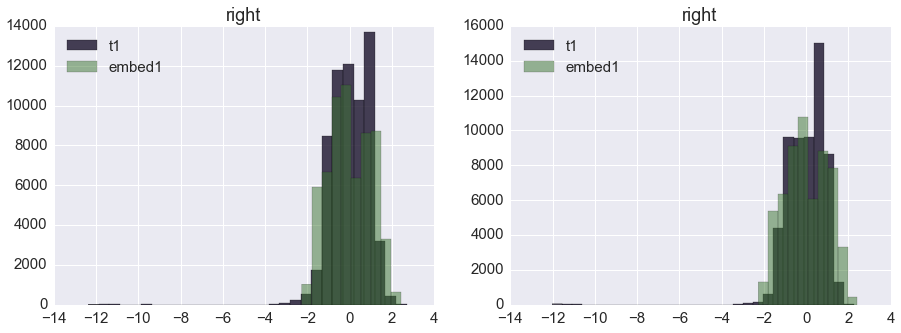

In [14]:
fig=plt.figure(figsize=(15,5))
fig.add_subplot(121)
plt.hist(lh_t1_norm, alpha=0.8, color=colors[0], label='t1', bins=30);
plt.hist(lh_embed1_norm, alpha=0.5, color=colors[3], label='embed1');
plt.title('left')
plt.title('right')
plt.legend(loc=2)
fig.add_subplot(122)
plt.hist(rh_t1_norm, alpha=0.8, color=colors[0], label='t1', bins=30);
plt.hist(rh_embed1_norm, alpha=0.5, color=colors[3], label='embed1');
plt.title('right')
plt.legend(loc=2)

### Functions

In [15]:
def custom_plot(x, y, res, xlabel=None, ylabel=None, data_color=colors[1]):
    fig=plt.figure(figsize=(12,5))
    fig.add_subplot(121)
    plt.plot(x, y, alpha=0.1, marker='.', linestyle='None', color=data_color)
    plt.plot(x, res.best_fit, color='black', linestyle='None', marker='.', markersize=.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    fig.add_subplot(122)
    res.plot_residuals(data_kws={'alpha':0.1, 'color':'grey', 'marker':'.'}, fit_kws={'color':'k', 'linewidth':2})
    
def custom_report(res):
    print 'BIC', res.bic
    print 'AIC', res.aic

In [16]:
def fit_simple(model, x, y, xlabel, ylabel, color):
    
    pars = model.guess(y, x=x)
    out = model.fit(y, pars, x=x)
    
    custom_report(out)
    custom_plot(x,y, out, xlabel=xlabel, ylabel=ylabel, data_color=color)
    
    return out

In [17]:
def fit_composite_const(model, x, y, xlabel, ylabel, color):
    
    const_model = lmfit.models.LinearModel(prefix='const_')
    const_model.set_param_hint(name='slope', value=0, vary=False)
    comp_model = model + const_model
    
    pars = const_model.make_params(intercept=y.min())
    pars += model.guess(y, x=x)
    out = comp_model.fit(y, pars, x=x)
    
    custom_report(out)
    custom_plot(x,y, out, xlabel=xlabel, ylabel=ylabel, data_color=color)
    
    return out

In [18]:
def plot_side(data, v, f, sulc, hemi):
    sns.set_style('white')
    
    
    if hemi == 'right':
        lat=plot_surf_stat_map(v, f, stat_map=data, bg_map=sulc, bg_on_stat=True, darkness=0.5, 
                            elev=180,azim=0, figsize=(11,10.5) ,threshold=1e-50, cmap='jet') 

        sns.set_style('white')
        med=plot_surf_stat_map(v, f, stat_map=data, bg_map=sulc, bg_on_stat=True,darkness=0.5,
                elev=180,azim=180, figsize=(11,10.5), threshold=1e-50, cmap='jet')

        lat_crop=crop_img(lat)
        med_crop=crop_img(med)

        fig=plt.figure()
        fig.set_size_inches(16, 8)
        ax1 = fig.add_subplot(121)
        plt.imshow(lat_crop)
        ax1.set_axis_off()
        ax2 = fig.add_subplot(122)
        plt.imshow(med_crop)
        ax2.set_axis_off()
        
        
    elif hemi == 'left':
        lat=plot_surf_stat_map(v, f, stat_map=data, bg_map=sulc, bg_on_stat=True, darkness=0.5, 
                            elev=180,azim=0, figsize=(11,9) ,threshold=1e-50, cmap='jet') 

        sns.set_style('white')
        med=plot_surf_stat_map(v, f, stat_map=data, bg_map=sulc, bg_on_stat=True,darkness=0.5,
                elev=180,azim=180, figsize=(11,9), threshold=1e-50, cmap='jet')

        lat_crop=crop_img(lat)
        med_crop=crop_img(med)

        fig=plt.figure()
        fig.set_size_inches(16, 8)
        ax1 = fig.add_subplot(121)
        plt.imshow(lat_crop)
        ax1.set_axis_off()
        ax2 = fig.add_subplot(122)
        plt.imshow(med_crop)
        ax2.set_axis_off()

### Choose data

In [19]:
data= rh_myeratio_norm
data_label = 'Myeratio FWHM=3mm'
data_cortex = rh_myeratio
mask = rh_mask

### Model

BIC -16661.7757259
AIC -16688.7514198


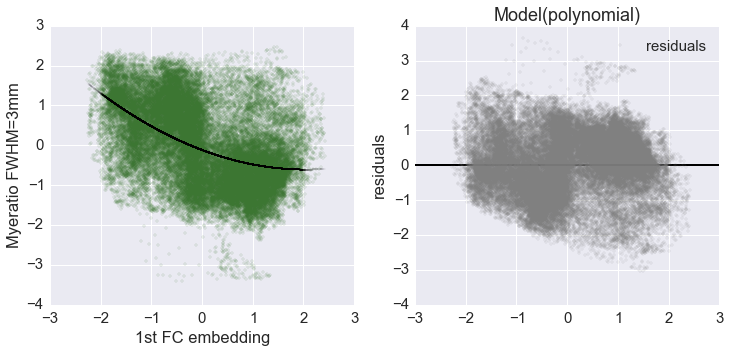

In [20]:
sns.set_style('darkgrid')
poly2_mod = lmfit.models.PolynomialModel(degree=2)

poly2_t1 = fit_simple(poly2_mod, 
                        x=rh_embed1_norm, y=data,
                        xlabel='1st FC embedding',
                        ylabel=data_label, 
                        color=colors[3])

BIC -19461.1709927
AIC -19497.1385846


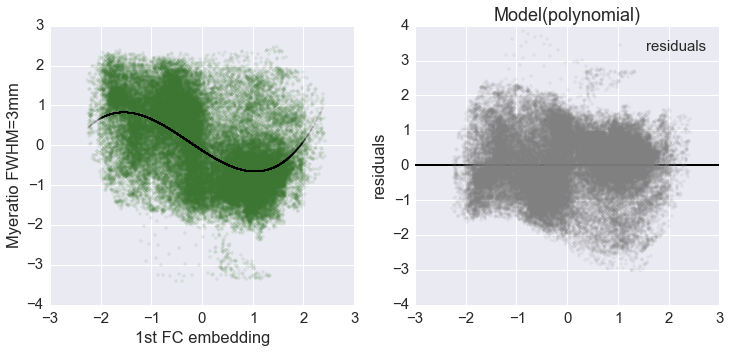

In [21]:
poly3_mod = lmfit.models.PolynomialModel(degree=3)

poly3_t1 = fit_simple(poly3_mod, 
                        x=rh_embed1_norm, y=data,
                        xlabel='1st FC embedding',
                        ylabel=data_label, 
                        color=colors[3])

BIC -19658.121008
AIC -19694.0885999


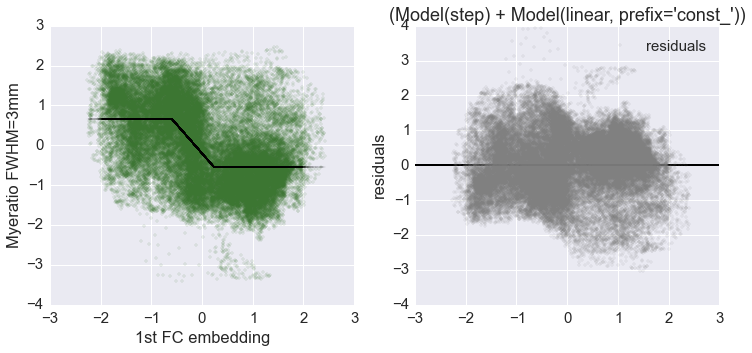

In [22]:
step_lin_mod = lmfit.models.StepModel(form='linear')

step_lin_const_t1 = fit_composite_const(step_lin_mod,
                                        x=rh_embed1_norm, y=data,
                                        xlabel='1st FC embedding',
                                        ylabel=data_label, 
                                        color=colors[3])

In [23]:
print 'quadratic', stats.pearsonr(poly2_t1.best_fit, data)[0]
print 'degree 3', stats.pearsonr(poly3_t1.best_fit, data)[0]
print 'step function', stats.pearsonr(step_lin_const_t1.best_fit, data)[0]

quadratic 0.495060150293
degree 3 0.529138276136
step function 0.531385959004


### Residuals on brain

In [24]:
idcs=np.arange(0,data_cortex.shape[0])
nonmask=np.delete(idcs, mask)

In [25]:
poly3_norm = (poly3_t1.best_fit - np.mean(poly3_t1.best_fit))/np.std(poly3_t1.best_fit)
step_norm = (step_lin_const_t1.best_fit - np.mean(step_lin_const_t1.best_fit))/np.std(step_lin_const_t1.best_fit)

In [26]:
predicted_poly3 = np.zeros_like(data_cortex)
predicted_poly3[nonmask] = poly3_norm
predicted_step = np.zeros_like(data_cortex)
predicted_step[nonmask] = step_norm
orig = np.zeros_like(data_cortex)
orig[nonmask] = data
orig_embed = np.zeros_like(data_cortex)
orig_embed[nonmask] = rh_embed1_norm

ERROR! Session/line number was not unique in database. History logging moved to new session 2038


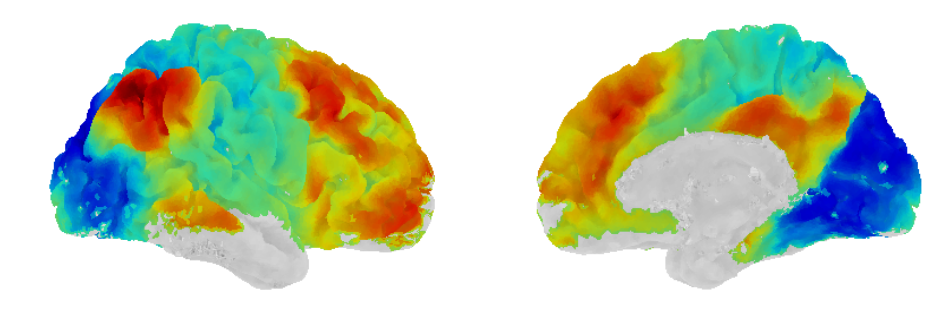

In [27]:
plot_side(orig_embed, rv, rf, rh_sulc, 'right')

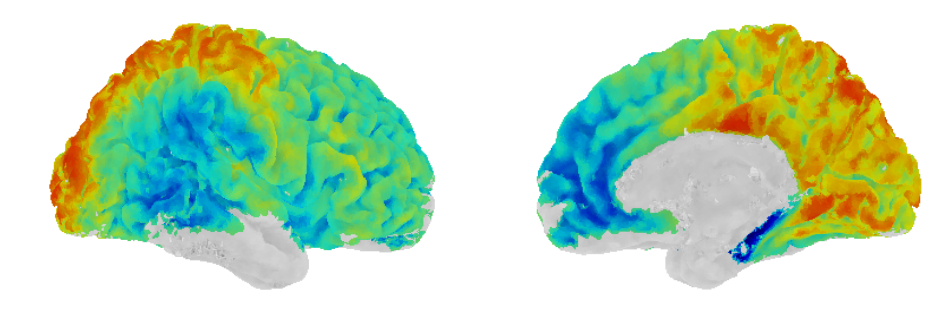

In [28]:
plot_side(orig, rv, rf, rh_sulc, 'right')

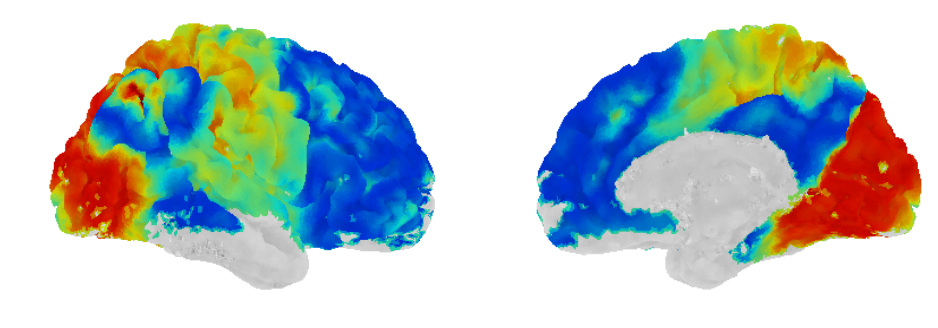

In [29]:
plot_side(predicted_poly3, rv, rf, rh_sulc, 'right')

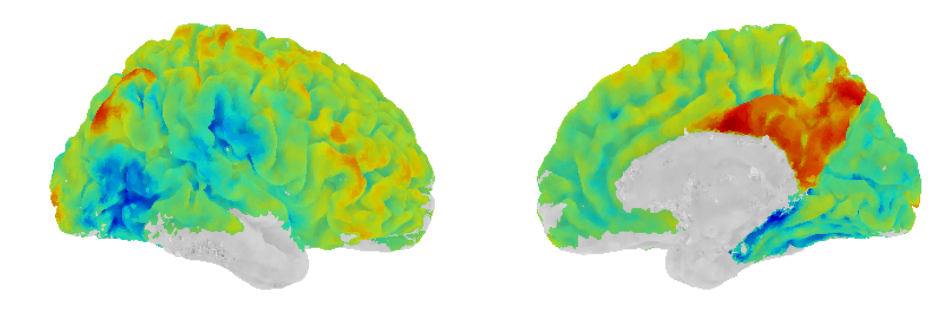

In [30]:
plot_side(orig-predicted_poly3, rv, rf, rh_sulc, 'right')

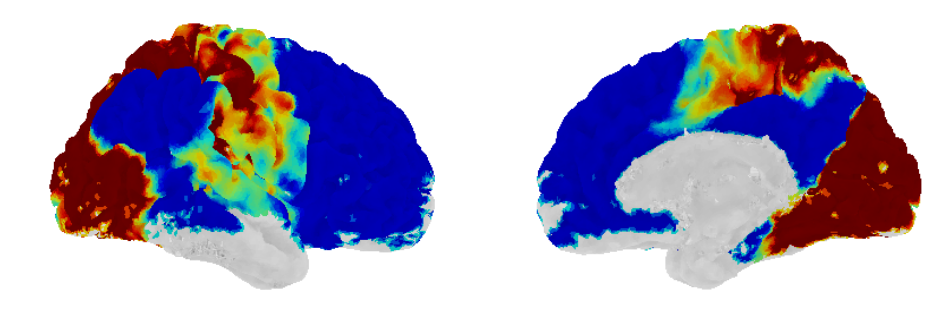

In [31]:
plot_side(predicted_step, rv, rf, rh_sulc, 'right')

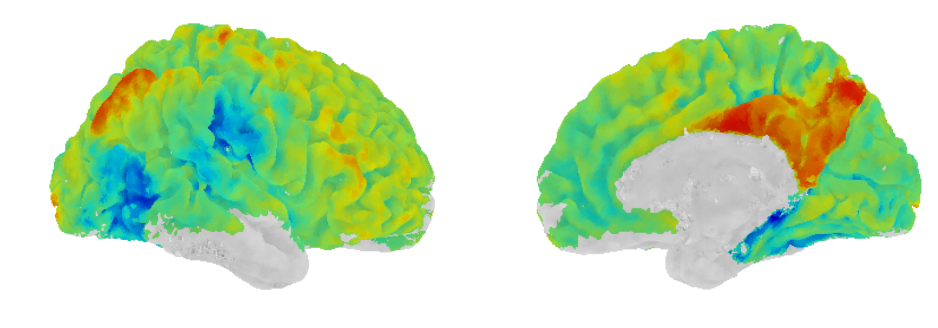

In [32]:
plot_side(orig-predicted_step, rv, rf, rh_sulc, 'right')

### Splitting based on FC

In [33]:
fc_pos = np.where(rh_scatter_embed[:,0]>0)
fc_neg = np.where(rh_scatter_embed[:,0]<0)

scatter_embed_pos = np.delete(rh_scatter_embed, fc_neg, axis=0)
scatter_embed_neg = np.delete(rh_scatter_embed, fc_pos, axis=0)

scatter_myeratio_pos = np.delete(rh_scatter_myeratio, fc_neg)
scatter_myeratio_neg = np.delete(rh_scatter_myeratio, fc_pos)

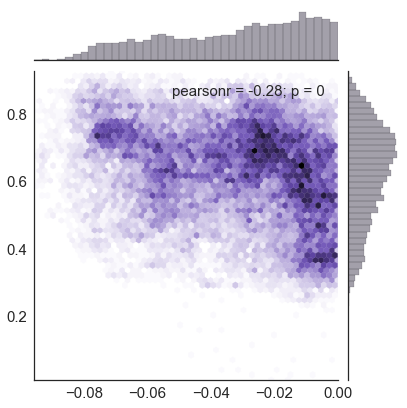

In [34]:
g = sns.jointplot(scatter_embed_neg[:,0], scatter_myeratio_neg, kind="hex", size=6, color=colors[0])
#g.set_axis_labels('FC', 'T1', fontsize=16)

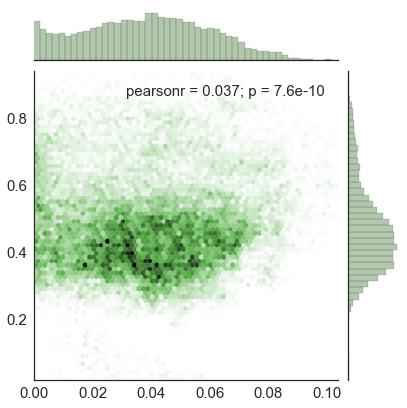

In [35]:
g = sns.jointplot(scatter_embed_pos[:,0], scatter_myeratio_pos, kind="hex", size=6, color=colors[3])
#g.set_axis_labels('FC', 'T1', fontsize=16)

In [36]:
fc_neg_pos = np.where(scatter_embed_neg[:,1]>0)
fc_neg_neg = np.where(scatter_embed_neg[:,1]<0)

scatter_embed_neg_pos = np.delete(scatter_embed_neg, fc_neg_pos, axis=0)
scatter_embed_neg_neg = np.delete(scatter_embed_neg, fc_neg_neg, axis=0)

scatter_myeratio_neg_pos = np.delete(scatter_myeratio_neg, fc_neg_pos)
scatter_myeratio_neg_neg = np.delete(scatter_myeratio_neg, fc_neg_neg)

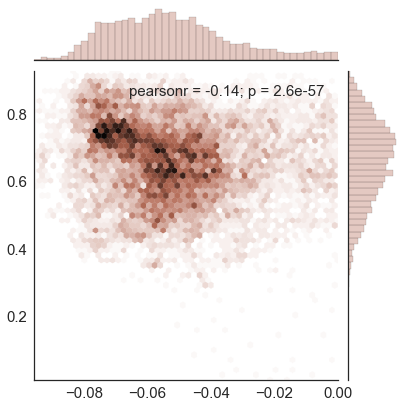

In [37]:
g = sns.jointplot(scatter_embed_neg_neg[:,0], scatter_myeratio_neg_neg, kind="hex", size=6, color=colors[5])
#g.set_axis_labels('FC', 'T1', fontsize=16)

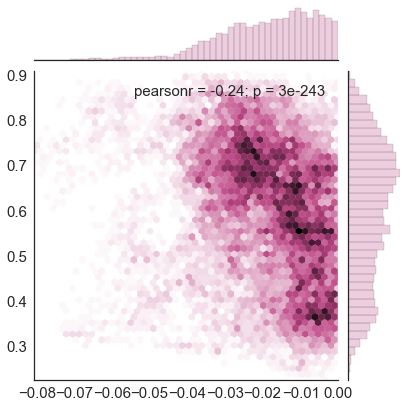

In [38]:
g = sns.jointplot(scatter_embed_neg_pos[:,0], scatter_myeratio_neg_pos, kind="hex", size=6, color=colors[6])
#g.set_axis_labels('FC', 'T1', fontsize=16)

In [39]:
fc_pos_pos = np.where(scatter_embed_pos[:,1]>0)
fc_pos_neg = np.where(scatter_embed_pos[:,1]<0)

scatter_embed_pos_pos = np.delete(scatter_embed_pos, fc_pos_pos, axis=0)
scatter_embed_pos_neg = np.delete(scatter_embed_pos, fc_pos_neg, axis=0)

scatter_myeratio_pos_pos = np.delete(scatter_myeratio_pos, fc_pos_pos)
scatter_myeratio_pos_neg = np.delete(scatter_myeratio_pos, fc_pos_neg)

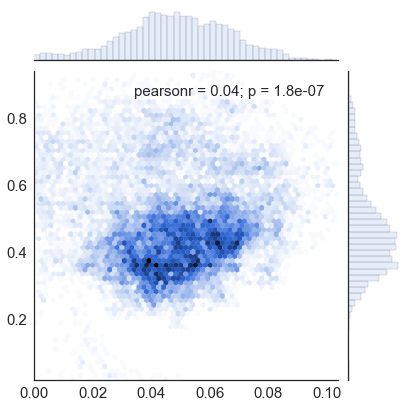

In [40]:
g = sns.jointplot(scatter_embed_pos_neg[:,0], scatter_myeratio_pos_neg, kind="hex", size=6, color=colors[8])
#g.set_axis_labels('FC', 'T1', fontsize=16)

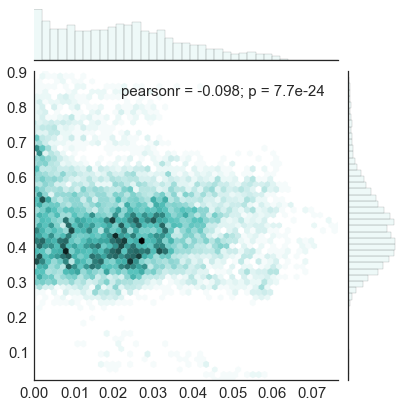

In [41]:
g = sns.jointplot(scatter_embed_pos_pos[:,0], scatter_myeratio_pos_pos, kind="hex", size=6, color=colors[9])
#g.set_axis_labels('FC', 'T1', fontsize=16)

In [42]:
fc=rh_embed[:,0]
fc[mask]=0
pos = np.where(rh_embed[:,0]>0)[0]
neg = np.where(rh_embed[:,0]<0)[0]
neg_neg = np.where((rh_embed[:,0] <0) & (rh_embed[:,1] <0))[0]
neg_pos = np.where((rh_embed[:,0] <0) & (rh_embed[:,1] >0))[0]
pos_neg = np.where((rh_embed[:,0] >0) & (rh_embed[:,1] <0))[0]
pos_pos = np.where((rh_embed[:,0] >0) & (rh_embed[:,1] >0))[0]

In [43]:
from plotting import plot_surf_label

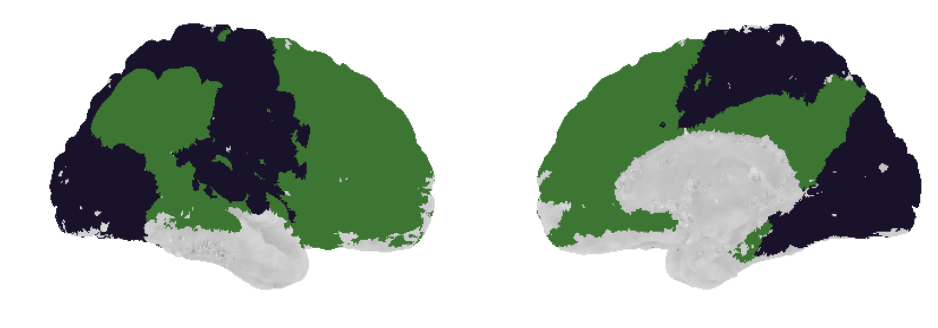

In [46]:
sns.set_style('white')
lat=plot_surf_label(rv, rf, labels=[neg, pos], bg_map=rh_sulc, #bg_on_labels=True, 
                darkness=0.5, figsize=(11,10.5), azim=0, elev=180, cpal=[colors[0], colors[3]])

sns.set_style('white')
med=plot_surf_label(rv, rf, labels=[neg, pos], bg_map=rh_sulc, #bg_on_labels=True, 
                darkness=0.5, figsize=(11,10.5), azim=180, elev=180, cpal=[colors[0], colors[3]])
        
lat_crop=crop_img(lat)
med_crop=crop_img(med)

fig=plt.figure()
fig.set_size_inches(16, 8)
ax1 = fig.add_subplot(121)
plt.imshow(lat_crop)
ax1.set_axis_off()
ax2 = fig.add_subplot(122)
plt.imshow(med_crop)
ax2.set_axis_off()

In [ ]:
sns.set_style('white')
lat=plot_surf_label(rv, rf, labels=[neg_neg, neg_pos, pos_neg, pos_pos], bg_map=rh_sulc, #bg_on_labels=True, 
                darkness=0.5, figsize=(11,10.5), azim=0, elev=180, cpal=[colors[5], colors[6], colors[8], colors[9]])

sns.set_style('white')
med=plot_surf_label(rv, rf, labels=[neg_neg, neg_pos, pos_neg, pos_pos], bg_map=rh_sulc, #bg_on_labels=True, 
                darkness=0.5, figsize=(11,10.5), azim=180, elev=180, cpal=[colors[5], colors[6], colors[8], colors[9]])
        
lat_crop=crop_img(lat)
med_crop=crop_img(med)

fig=plt.figure()
fig.set_size_inches(16, 8)
ax1 = fig.add_subplot(121)
plt.imshow(lat_crop)
ax1.set_axis_off()
ax2 = fig.add_subplot(122)
plt.imshow(med_crop)
ax2.set_axis_off()

### Myelin as linear combination of embedding maps

In [ ]:
from sklearn import linear_model

In [ ]:
maps = [0,4]

clf = linear_model.LinearRegression()
clf.fit(rh_scatter_embed[:,maps], rh_scatter_myeratio)
print clf.coef_
print clf.score(rh_scatter_embed[:,maps], rh_scatter_myeratio)

In [ ]:
modelled_fit = np.dot(rh_scatter_embed[:,maps],clf.coef_)
print stats.pearsonr(modelled_fit, rh_scatter_myeratio)

In [ ]:
fit_norm = (modelled_fit - np.mean(modelled_fit)) / np.std(modelled_fit)

In [ ]:
plot_fit = np.zeros_like(data_cortex)
plot_fit[nonmask] = fit_norm

In [ ]:
plot_side(orig, rv, rf, rh_sulc, 'right')

In [ ]:
plot_side(plot_fit, rv, rf, rh_sulc, 'right')

In [ ]:
plot_side((orig-plot_fit), rv, rf, rh_sulc, 'right')

### Formal clustering based on myelin and FC embedding

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
features=np.vstack((rh_myeratio_norm, rh_embed1_norm, rh_embed2_norm)).T

In [ ]:
for k in [2,3,4,5]:
    est = KMeans(n_clusters=k, n_jobs=-2, init='k-means++', n_init=300)
    est.fit_transform(features)
    labels = est.labels_
    plot_kmeans = np.zeros_like(data_cortex)
    plot_kmeans[nonmask] = (labels+1)
    plot_side(plot_kmeans, rv, rf, rh_sulc, 'right')